In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns

In [2]:
data_dir = Path.cwd().parent / 'DATA'
data = {
    "train": data_dir / "train_data.csv",
    "test": data_dir / "test_data.csv",
    "sample": data_dir / "sample_solotion.csv",
}

In [3]:
%%time
train_df = pd.read_csv(data["train"])
print(f"training dataframe -> rows: {train_df.shape[0]}, cols: {train_df.shape[1]}")
train_mem_size = train_df.memory_usage(deep=True).sum() / 1024
print(f"-- memory usage: {round(train_mem_size):,} MB")

training dataframe -> rows: 375734, cols: 246
-- memory usage: 761,726 MB
CPU times: total: 7.02 s
Wall time: 8.85 s


In [4]:
%%time
test_df = pd.read_csv(data["test"])
print(f"training dataframe -> rows: {test_df.shape[0]}, cols: {test_df.shape[1]}")
test_mem_size = test_df.memory_usage(deep=True).sum() / 1024
print(f"-- memory usage: {round(test_mem_size):,} MB")

training dataframe -> rows: 31354, cols: 245
-- memory usage: 63,342 MB
CPU times: total: 562 ms
Wall time: 741 ms


In [5]:
TARGET = "contest-tmp2m-14d__tmp2m"

In [6]:
FIG_SIZE = (15, 9)

In [9]:
dfs = {
    "train": train_df,
    "test": test_df,
}

In [10]:
def survey_locations(in_df: pd.DataFrame) -> None:
    print("location survey:")
    in_df["coord"] = in_df.apply(lambda x: (x["lat"], x["lon"]), axis=1)
    for col in ["lat", "lon", "coord"]:
        n = len(in_df[col].unique())
        print(f"-- unique {col} values: {n}")
    uniq_coord = [{"Latitude": c[0], "Longitude": c[1]} for c in in_df["coord"].unique().tolist()]
    xy_df = pd.DataFrame(uniq_coord)
    xy_df.plot(x="Longitude", y="Latitude", kind="scatter", figsize=FIG_SIZE)
    plt.grid()
    plt.show()
    print()

In [11]:
def survey_dates(in_df: pd.DataFrame) -> None:
    print("date survey:")
    dates = in_df["startdate"].unique().copy()
    print(f"unique dates: {len(dates)}")
    in_df["date"] = pd.to_datetime(in_df["startdate"])
    start_date = in_df["date"].min()
    end_date = in_df["date"].max()
    print(f"- from {start_date} to {end_date}")
    date_diff = (in_df["date"] - start_date).dt.days
    print(f"- max difference: {date_diff.max() + 1}")
    print()

TRAIN dataset ======================
location survey:
-- unique lat values: 23
-- unique lon values: 31
-- unique coord values: 514


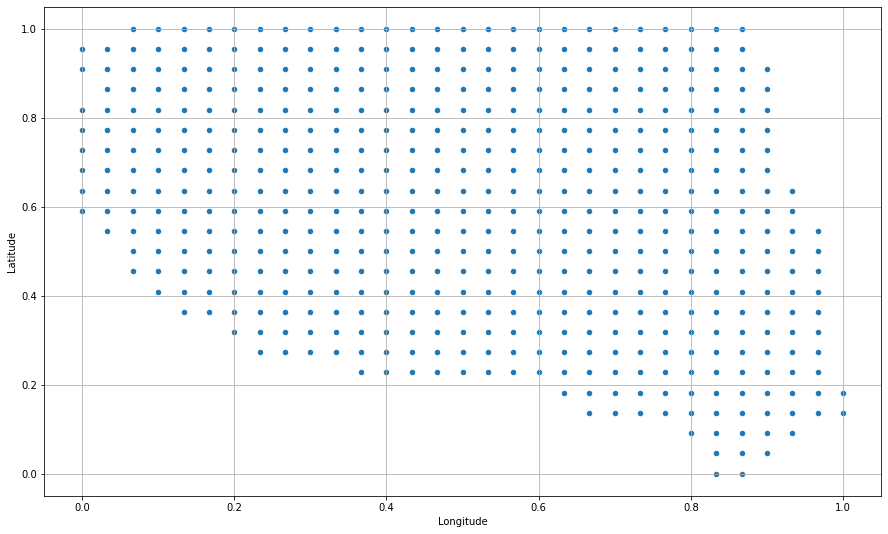


date survey:
training dates: 731
- from 2014-09-01 00:00:00 to 2016-08-31 00:00:00
- max difference: 731

TEST dataset ======================
location survey:
-- unique lat values: 23
-- unique lon values: 31
-- unique coord values: 514


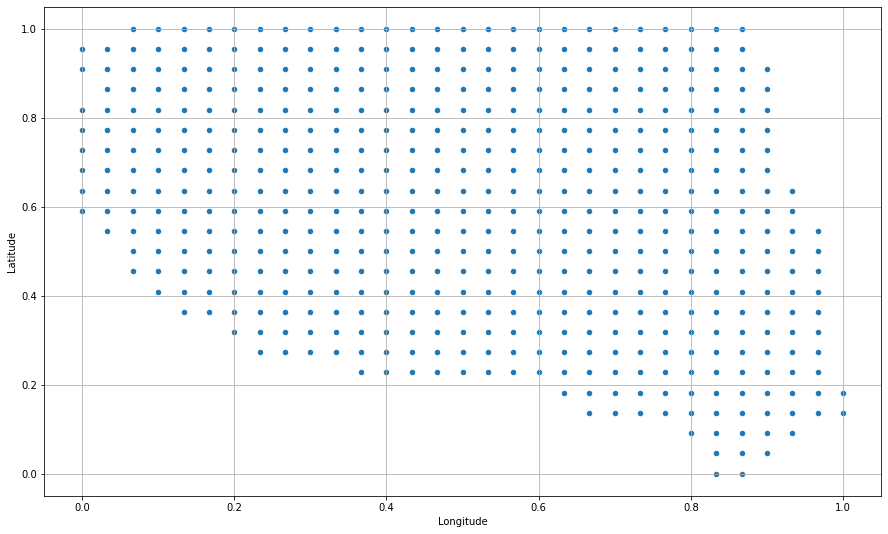


date survey:
training dates: 61
- from 2022-11-01 00:00:00 to 2022-12-31 00:00:00
- max difference: 61



In [12]:
for df_label, df in dfs.items():
    print(f"{df_label.upper()} dataset ======================")
    survey_locations(in_df=df)
    survey_dates(in_df=df)

In [13]:
train_locations = train_df["coord"].unique().tolist()

In [14]:
N_SAMPLES = 7

TARGET temperature (contest-tmp2m-14d__tmp2m) for various locations

location 0: (0.0, 0.8333333333333334)
location 391: (0.8181818181818182, 0.4)
location 109: (0.3636363636363636, 0.4666666666666667)
location 81: (0.3181818181818182, 0.4)
location 435: (0.9090909090909092, 0.0333333333333333)
location 500: (1.0, 0.4333333333333333)
location 379: (0.8181818181818182, 0.0)



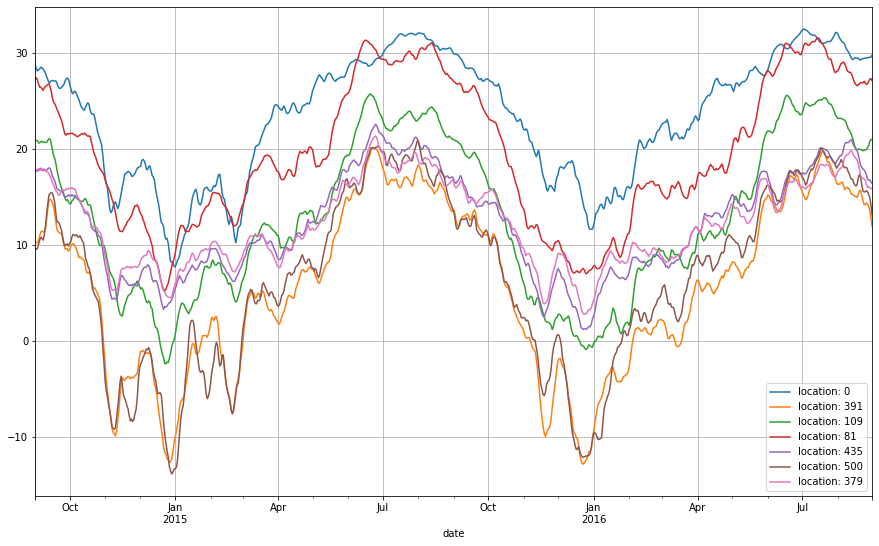


Sampled locations:



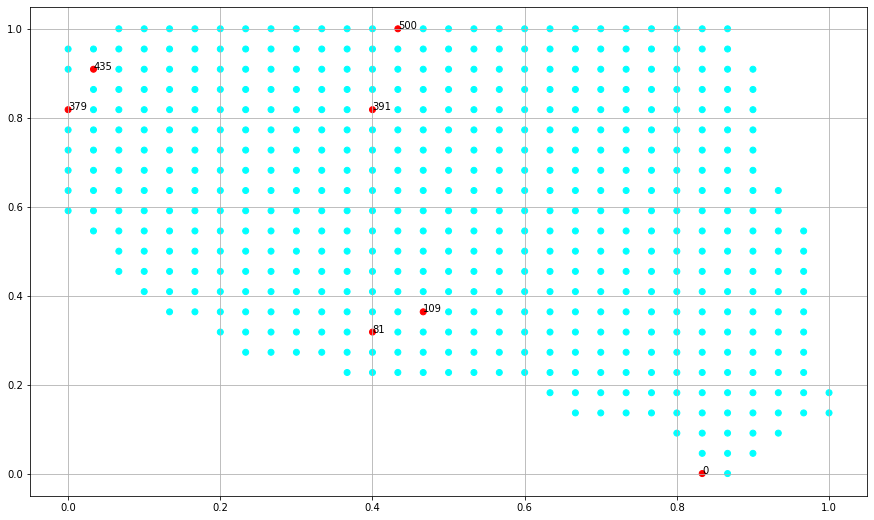

Correlation Matrix:



,location: 0,location: 391,location: 109,location: 81,location: 435,location: 500,location: 379
location: 0,1.000,0.940,0.931,0.921,0.915,0.948,0.894
location: 391,0.940,1.000,0.972,0.969,0.978,0.981,0.970
location: 109,0.931,0.972,1.000,0.997,0.961,0.947,0.946
location: 81,0.921,0.969,0.997,1.000,0.959,0.945,0.945
location: 435,0.915,0.978,0.961,0.959,1.000,0.962,0.991
location: 500,0.948,0.981,0.947,0.945,0.962,1.000,0.945
location: 379,0.894,0.970,0.946,0.945,0.991,0.945,1.000


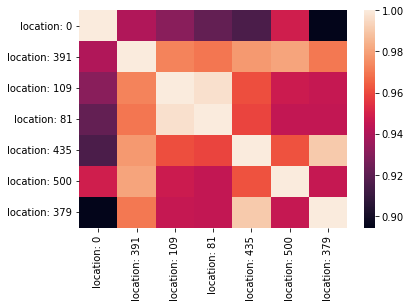

In [15]:
print(f"TARGET temperature ({TARGET}) for various locations\n")
smpl_list = set(random.randint(0, len(train_locations)) for i in range(N_SAMPLES))
smpl_locations = []
# time series plot
for n, sample in enumerate(smpl_list):
    smpl_location = train_locations[sample]
    smpl_locations.append(smpl_location)
    print(f"location {sample}: {smpl_location}")
    if not n:
        plot_data = train_df.loc[train_df["coord"] == smpl_location, ["date"]]
        plot_data.columns = ["date"]
        plot_data.reset_index(drop=True, inplace=True)
    crnt_smpl = train_df.loc[train_df["coord"] == smpl_location, [TARGET]]
    crnt_smpl.columns = [f"location: {str(sample)}"]
    crnt_smpl.reset_index(drop=True, inplace=True)
    plot_data = plot_data.merge(crnt_smpl, left_index=True, right_index=True)
print()
plot_data.head()
plot_data.set_index("date", drop=True, inplace=True)
plot_data.plot(figsize=FIG_SIZE)
plt.grid()
plt.show()

# location plot
coord_list = [
    {
        "color": "cyan",
        "coord": coord
    }
    for coord in train_locations
    if coord not in smpl_locations
]
for coord in smpl_locations:
    coord_list.append({
        "color": "red",
        "coord": coord,
    })
coord_df = pd.DataFrame(coord_list)
coord_df["Latitude"], coord_df["Longitude"] = coord_df["coord"].str[0], coord_df["coord"].str[1]
print("\nSampled locations:\n")
fig, ax = plt.subplots(figsize=FIG_SIZE)
ax.scatter(
    x=coord_df["Longitude"],
    y=coord_df["Latitude"],
    c=coord_df["color"],
)
for i, txt in enumerate(smpl_list):
    ax.annotate(txt, (smpl_locations[i][1], smpl_locations[i][0]))
plt.grid()
plt.show()

# correlation between locations
print("Correlation Matrix:\n")
cormat = plot_data.corr()
display(round(cormat,3))
sns.heatmap(cormat)
plt.show()

In [18]:
smpl_data = train_df[train_df["coord"] == smpl_location]
print(f"sample location data frame -> rows: {smpl_data.shape[0]}, cols: {smpl_data.shape[1]}")

sample location data frame -> rows: 731, cols: 248


In [71]:
THRSHLD = 0.9

In [73]:
def column_corr(in_df: pd.DataFrame, constant_cols: list) -> None:
    trgt_corr = in_df.corr(numeric_only=True)[TARGET].sort_values(ascending=False)
    all_cols = trgt_corr.index.to_list()
    skip_cols = [TARGET]
    skip_cols.extend(constant_cols)
    keep_cols = [c for c in all_cols if c not in skip_cols]
    trgt_corr = trgt_corr[trgt_corr.index.isin(keep_cols)]
    trgt_corr.name = "correlation"
    corr_df = pd.DataFrame(trgt_corr)
    corr_df["abs. corr."] = corr_df["correlation"].abs()
    top_corr_df = corr_df[corr_df["abs. corr."] >= THRSHLD]
    print(f"columns w/ abs. corr. above {THRSHLD}: {top_corr_df.shape[0]}")
    display(top_corr_df)

In [77]:
print(f"Sample data, location: {sample}")
column_corr(in_df=smpl_data, constant_cols=["lat", "lon", "elevation__elevation"])

Sample data, location: 379
columns w/ abs. corr. above 0.9: 24


,correlation,abs. corr.
nmme-tmp2m-34w__cfsv2,0.932577,0.932577
nmme-tmp2m-56w__cfsv2,0.931208,0.931208
nmme-tmp2m-34w__nmmemean,0.922805,0.922805
nmme-tmp2m-56w__gfdl,0.922607,0.922607
nmme-tmp2m-56w__nasa,0.922473,0.922473
contest-pevpr-sfc-gauss-14d__pevpr,0.922000,0.922000
nmme-tmp2m-34w__nasa,0.921222,0.921222
nmme-tmp2m-56w__nmmemean,0.920473,0.920473
nmme-tmp2m-34w__cancm4,0.919799,0.919799
nmme-tmp2m-56w__cancm4,0.917398,0.917398


In [78]:
print("All training data")
column_corr(in_df=train_df, constant_cols=[])

All training data
columns w/ abs. corr. above 0.9: 20


,correlation,abs. corr.
nmme-tmp2m-56w__cfsv2,0.954668,0.954668
nmme-tmp2m-34w__cfsv2,0.954483,0.954483
nmme-tmp2m-56w__nmmemean,0.950865,0.950865
nmme-tmp2m-34w__nmmemean,0.950187,0.950187
nmme-tmp2m-56w__gfdlflora,0.949846,0.949846
nmme-tmp2m-34w__gfdlflorb,0.949346,0.949346
nmme-tmp2m-56w__gfdlflorb,0.949016,0.949016
nmme-tmp2m-34w__gfdlflora,0.947379,0.947379
nmme-tmp2m-56w__ccsm4,0.944435,0.944435
nmme-tmp2m-34w__ccsm4,0.943234,0.943234


In [129]:
# categorical columns
cat_cols = []
for col in train_df.columns:
    if len(train_df[col].unique()) < 25 and col not in ["lat", "lon"]:
        print(col)
        cat_cols.append(col)
        display(train_df[col].value_counts())
        print()

climateregions__climateregion


BSk    139621
Dfb     52632
Cfa     51901
Csb     40936
Dfa     22661
BWk     13889
Dfc     12427
BWh      9503
Csa      9503
Dsb      8041
BSh      5117
Cfb      4386
Dsc      2924
Dwa      1462
Dwb       731
Name: climateregions__climateregion, dtype: int64


mjo1d__phase


4    59110
3    50372
7    49344
1    47802
6    46260
2    43690
8    41120
5    38036
Name: mjo1d__phase, dtype: int64


mei__meirank


67    94062
66    78128
48    30326
37    22102
44    15934
47    15934
53    15934
63    15934
64    15934
49    15420
51    15420
61    15420
60    15420
56     9766
Name: mei__meirank, dtype: int64


mei__nip


4    291438
3     84296
Name: mei__nip, dtype: int64

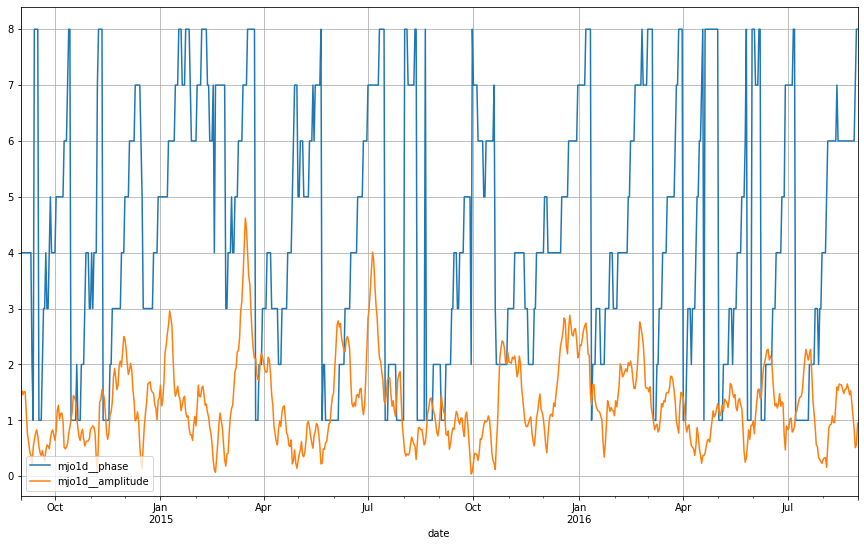

In [105]:
smpl_data.plot(kind="line", x="date", y=["mjo1d__phase", "mjo1d__amplitude"], figsize=FIG_SIZE)
plt.grid()
plt.show()

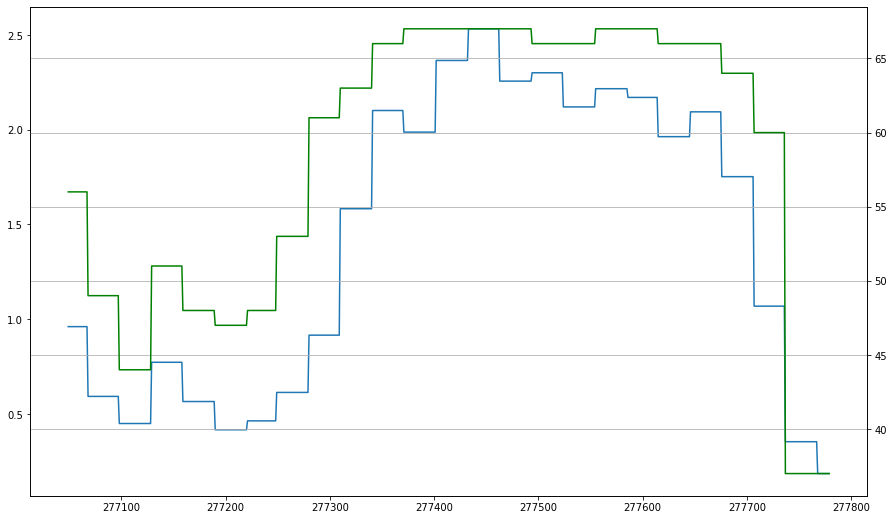

In [123]:
smpl_data["mei__mei"].plot(kind="line", x="date", figsize=FIG_SIZE)
smpl_data["mei__meirank"].plot(kind="line", secondary_y=True, style="g")
plt.grid()
plt.show()